# Annotation Analysis | Hypothesis | SFU Courses

In [1]:
import configparser
import datetime
import json
import re
from statistics import mean, median
from pathlib import Path
import calendar

from tabulate import tabulate
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import requests

In [6]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_palette("Paired")

savefigs = True

URL_PATTERN = "((http|ftp|https):\/\/[\w\-_]+(\.[\w\-_]+)" \
              "([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?)"

data_dir = Path("../data")
plot_dir =   Path("../plots")

groups_file = data_dir / "groups.csv"
comments_file = data_dir / "comments.csv"
readings_file = data_dir / "readings.csv"

## Load and process data

In [93]:
groups = pd.read_csv(str(groups_file), index_col="id")
comments = pd.read_csv(str(comments_file), index_col="id",
                       parse_dates=['created', 'updated'])

In [95]:
groups

,group,group_name,course,course_title,instructor,email,url
id,,,,,,,
1,A2PQgMrN,cmns432-spring2019-group1,CMNS 432,"Political Communication, Public Opinion, and P...",Daniel Ahadi,daniel_ahadi@sfu.ca,32.0
2,VJV347Nk,cmns432-spring2019-group2,CMNS 432,"Political Communication, Public Opinion, and P...",Daniel Ahadi,daniel_ahadi@sfu.ca,32.0
3,w49NKXMK,cputl-spring-2019,CPUTL,Certificate Program in University Teaching and...,Sarah Louise Turner,slt5@sfu.ca,16.0
4,LobrZD9V,gero-411,GERO 411,"Culture, Migration, and Aging",Sharon Koehn,skoehn@sfu.ca,14.0
5,yExRYE5x,sfu-gsws-319-sp19,GSWS 319,"Special Topics in Gender, Sexuality, and Women...",Tiffany Muller Myrdahl,tiffany_muller_myrdahl@sfu.ca,13.0
6,R4J1gJpq,iat206w-s2019-d103d103,IAT 206W,Media Across Cultures,Gabriela Aceves-Sepulveda,gabriela_aceves-sepulveda@sfu.ca,22.0
7,vazdPL1k,iat206w-s2019-d101d102,IAT 206W,Media Across Cultures,Gabriela Aceves-Sepulveda,gabriela_aceves-sepulveda@sfu.ca,22.0
8,k4bmbbKV,sfu-mpub-2018,PUB 802,Technology & Evolving Forms of Publishing,Juan Pablo Alperin,juan@alperin.ca,71.0
9,eDvvw53K,pub-social-change-spr19,PUB 480,NaN,Hannah McGregor,NaN,NaN


In [96]:
# Limit comments to 2019
comments = comments[comments.created > pd.Timestamp(datetime.date(2019, 1, 1))]
# Create some extra metrics for individual comments
comments['length'] = comments.text.map(lambda x: len(str(x)))
comments['created_day'] = comments.created.map(
    lambda x: datetime.datetime(year=x.year, month=x.month, day=x.day))
comments['Has URL'] = comments.text.map(lambda x: re.search(
    URL_PATTERN, x) is not None if not pd.isna(x) else None)

# Summary
comments.group_name.value_counts()

sfu-mpub-2018                4050
pub-social-change-spr19      1118
gero-411                      759
iat206w-s2019-d101d102        300
sfu-gsws-319-sp19             267
iat206w-s2019-d103d103        216
cputl-spring-2019             164
cmns432-spring2019-group1      94
cmns432-spring2019-group2      75
Name: group_name, dtype: int64

In [97]:
for xx in comments.group_name.unique():
    df = comments[comments.group_name == xx]
    df.to_csv("comments/{}.csv".format(xx))

cmns432-spring2019-group1
cmns432-spring2019-group2
cputl-spring-2019
gero-411
sfu-gsws-319-sp19
iat206w-s2019-d103d103
iat206w-s2019-d101d102
sfu-mpub-2018
pub-social-change-spr19


In [ ]:
readings = pd.read_csv(
    str(readings_file), index_col="id", parse_dates=['date'])

readings['month'] = readings.date.map(lambda x: x.month)
readings['week'] = readings.date.map(lambda x: x.week)
readings['week'] = readings['week'] - min(readings['week'])

In [9]:
# Select courses to analyse
courses_to_include = ["GERO 411"]

comments = comments[comments.course.isin(courses_to_include)]
readings = readings[readings.course.isin(courses_to_include)]

classes = pd.DataFrame(columns=["date"])
classes.index.name = "week"

classes.date = pd.date_range(
    start=min(readings.date), end=max(readings.date), freq='W-WED')
classes.index = classes.index + 1

In [10]:


comments.course.value_counts()

GERO 411    10626
Name: course, dtype: int64

In [7]:
months = {k: v for k, v in enumerate(calendar.month_abbr)}

In [18]:
readings[['group', 'course']].drop_duplicates()

,group,course
id,,
0,A2PQgMrN,CMNS 432
1,VJV347Nk,CMNS 432
64,w49NKXMK,CPUTL
80,LobrZD9V,GERO 411
94,yExRYE5x,GSWS 319
107,k4bmbbKV,PUB 802
178,vazdPL1k,IAT 206W
179,R4J1gJpq,IAT 206W


In [10]:
readings.loc[82].url

'https://www.dropbox.com/s/c2dy9lqmgp19d5h/Koehn%26%20Kobayashi%202011-Ch7-pre-proof%20draft.pdf?raw=1 '

## Plots & analyses

In [ ]:
pdf = comments.groupby(["created_day", "week", "course"]).count()[
    'text'].reset_index()
pdf.columns = ['Date', 'Week', "Course", 'Number of comments']

# Plot bubbles
g = sns.relplot(x="Date", y="Week", hue="Course", size="Number of comments", alpha=.9,
                sizes=(20, 200), palette="muted", data=pdf, height=8, aspect=1.5)
ax = g.facet_axis(0, 0)

# Plot class tick marks
for w, date in classes.itertuples(index=True):
    ax.vlines(date, w-.5, w+.5, colors="r", lw=3, alpha=1)
    plt.text(date+pd.Timedelta("1 days"), w-.7,
             "Week {}".format(w), fontsize=14, color="r")

# Formatting
ax.set_xlim((min(pdf.Date)-pd.Timedelta('1 days'),
             max(readings.date)+pd.Timedelta('1 days')))

weekFormatter = mdates.DateFormatter('%b %d')
ax.xaxis.set_major_formatter(weekFormatter)

mondays = mdates.WeekdayLocator(mdates.MONDAY)
ax.xaxis.set_major_locator(mondays)

plt.gcf().autofmt_xdate()

plt.xlabel("")
plt.title("Comments created througout the PUB 802")
ax.yaxis.set_visible(False)
sns.despine(right=True, top=True, left=True, bottom=True)

if savefigs:
    plt.savefig(str(plot_dir / "week_overview.png"), bbox_inches="tight")

## Comments per part, week, and readings

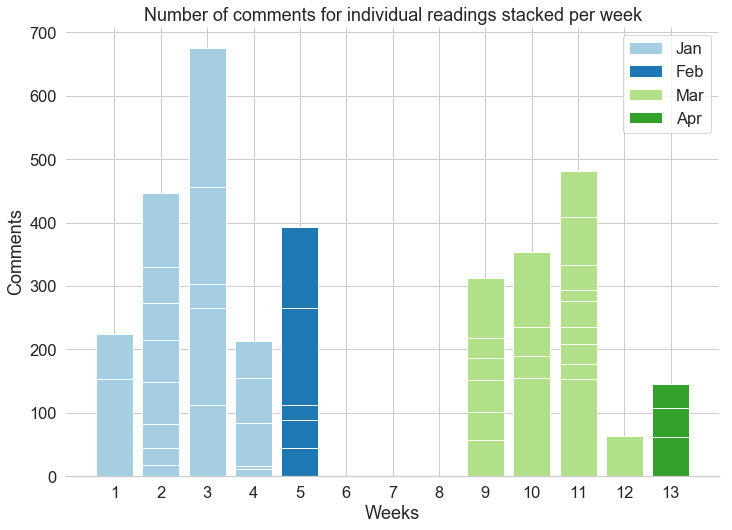

In [277]:
pdf = comments.groupby(["week", "month", "reading_id"])[
    'hypothesis_id'].count().reset_index()
pdf = pdf.rename(
    columns={'hypothesis_id': 'comments', 'reading_id': 'reading'})

month_colors = pdf.month.unique().tolist()
c = sns.color_palette(n_colors=len(month_colors))
colors = {m: col for m, col in zip(month_colors, c)}

for w in pdf.week.tolist()[::-1]:
    subdf = pdf[pdf.week == w]

    m = subdf['month'].iloc[0]
    if m in month_colors:
        label = months[m]
        month_colors.remove(m)
    else:
        label = None
    color = colors[m]

    rs = subdf.reading.tolist()
    plt.bar(w, subdf.comments.sum(), color=color, label=label)

    for r in subdf.reading.tolist():
        rs.remove(r)
        _ = subdf[subdf.reading.isin(rs)]
        plt.bar(w, _.comments.sum(), color=color)

plt.ylabel("Comments")
plt.xlabel("Weeks")
plt.title("Number of comments for individual readings stacked per week")
plt.xticks(range(1, int(max(pdf.week))+1))

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])

sns.despine(right=True, top=True, left=True)

if savefigs:
    plt.savefig(str(plot_dir / "comments_per_reading.png"),
                bbox_inches="tight")

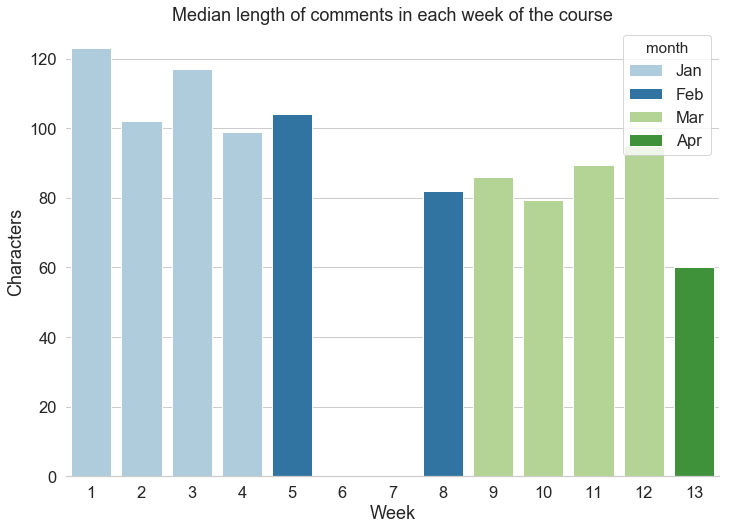

In [278]:
pdf = comments.groupby(["week", "month"])["length"].median().reset_index()

# Add missing weeks with no comments
for i in range(1, max(pdf.week)+1):
    if i not in pdf['week'].tolist():
        pdf.loc[len(pdf)+1] = [i, int(np.ceil(i/4)), 0]
pdf.month = pdf.month.map(lambda x: months[x])

# Create simple barplot
sns.barplot(x="week", y="length", hue="month", data=pdf, ci=None, dodge=False)

plt.ylabel("Characters")
plt.xlabel("Week")
plt.title("Median length of comments in each week of the course")

sns.despine(right=True, top=True, left=True)

if savefigs:
    plt.savefig(str(plot_dir / "med_comment_length.png"), bbox_inches="tight")

## Comments and median lenghts

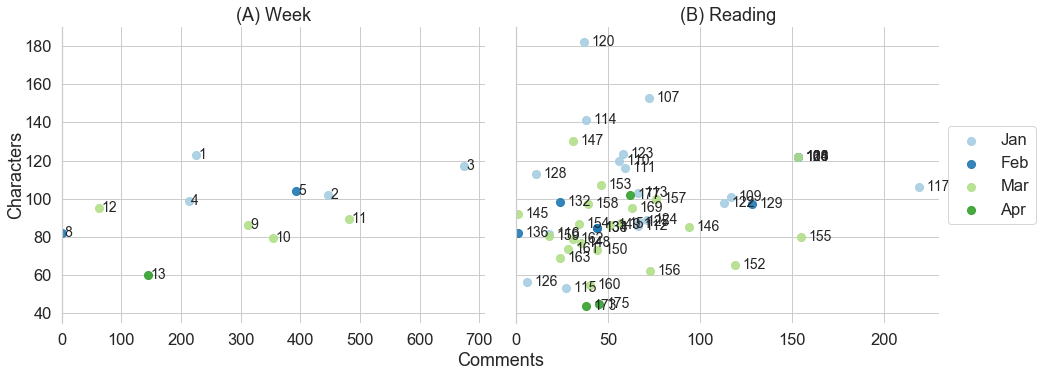

In [279]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

labels = ["(A) Week", "(B) Reading"]
for ax, by, l in zip(axes, ["week", "reading_id"], labels):
    df = pd.DataFrame()
    df['comments'] = comments.groupby(by)["length"].count()
    df['length'] = comments.groupby(by)["length"].median()
    df['month'] = comments.groupby(
        by)["month"].apply(lambda x: np.unique(x)[0])

    df.reset_index(inplace=True)

    for i in comments.month.unique():
        pdf = df[df.month == i]
        ax.scatter(pdf['comments'], pdf['length'],
                   s=65, alpha=0.9, label=months[i])

    for i, row in df.iterrows():
        ax.annotate(int(row[by]),
                    (row['comments']+4, row['length']),
                    horizontalalignment='left',
                    verticalalignment='center',
                    size=14)

    ax.set_title(l)
    ax.set_xlim(0, ax.get_xlim()[1])
    sns.despine(bottom=True, ax=ax)

box = axes[1].get_position()
axes[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off',
                bottom='off', left='off', right='off')
plt.grid(False)
plt.ylabel("Characters")
plt.xlabel("Comments")

plt.tight_layout()
plt.legend()

if savefigs:
    plt.savefig(str(plot_dir / "comments_vs_length.png"), bbox_inches="tight")

## Parts, weeks, readings per user

In [ ]:
labels = ["Part", "Week"]
fix, axes = plt.subplots(1, len(labels), figsize=(
    6.5*len(labels), 6), sharey=True)

for ax, by, l in zip(axes, ["month", "week"], labels):
    pdf = comments.groupby(["user", by])['text'].count().reset_index()
    sns.pointplot(x=by, y="text", hue="user", data=pdf, ax=ax,  lw=1)

    x = pdf.groupby([by]).mean()
    ax.plot(x.text.values, c="red", lw="5", zorder=100)

    ax.legend_.remove()
    ax.set_xlabel(l)
    ax.set_xticklabels([])
    ax.set_ylabel("Comments")
    sns.despine(right=True, top=True, ax=ax)
plt.tight_layout()

In [ ]:
labels = ["Part", "Week"]

fix, axes = plt.subplots(1, len(labels), figsize=(
    6.5*len(labels), 6), sharey=True)
for ax, by, l in zip(axes, ["month", "week"], labels):
    pdf = comments.groupby(["user", by])['length'].median().reset_index()
    sns.pointplot(x=by, y="length", hue="user", data=pdf, ax=ax,  s=.2)

    x = pdf.groupby([by]).mean()
    ax.plot(x.length.values, c="red", lw="5", zorder=100)

    ax.legend_.remove()
    ax.set_xlabel(l)
    ax.set_xticklabels([])
    ax.set_ylabel("Median length of comments")
    sns.despine(right=True, top=True, ax=ax)
plt.tight_layout()

## Number of comments and the median length

In [ ]:
counts = pd.DataFrame(columns=["total", "median"])
counts['total'] = comments.user.value_counts()
counts['median'] = comments.groupby("user")["text"].apply(
    lambda x: median([len(str(y)) for y in x.tolist()]))
# counts.rank(ascending=False).T.plot(legend=False)

col = sns.color_palette(n_colors=5)
pdf = counts.rank(ascending=False)
labels = []
for i, row in pdf.iterrows():
    plt.plot([row['total'], row['median']])
    labels.append(l)

# plt.legend(loc="right")
# Shrink current axis by 20%
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

ax1 = plt.gca()
ax1.set_ylim((0, 15))

ax2 = ax1.twinx()
ax2.set_ylim((0, 15))

ax1.set_yticks(range(1, 15))
ax2.set_yticks(range(1, 15))

labels_1 = []
for k, v in counts['total'].items():
    labels_1.append("{}: {}".format(k, v))
ax1.set_yticklabels(labels_1)

labels_2 = []
for k, v in counts['median'].sort_values().items():
    labels_2.append("{}".format(v))
ax2.set_yticklabels(labels_2)

ax1.invert_yaxis()

plt.title("Number of comments — Lenght of comments")
plt.xticks([0, 1], ["Comments", "Characters"])
ax1.grid(False)
ax2.grid(False)
ax1.yaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax1.tick_params(axis='y', pad=-25)
ax2.tick_params(axis='y', pad=-25)

# plt.subplots_adjust(hspace=0)

plt.tight_layout()
sns.despine(right=True, top=True, bottom=True, left=True, trim=True)

if savefigs:
    plt.savefig(str(plot_dir / "user_ranks_length_vs_comments.png"),
                bbox_inches="tight")

### Reading Times

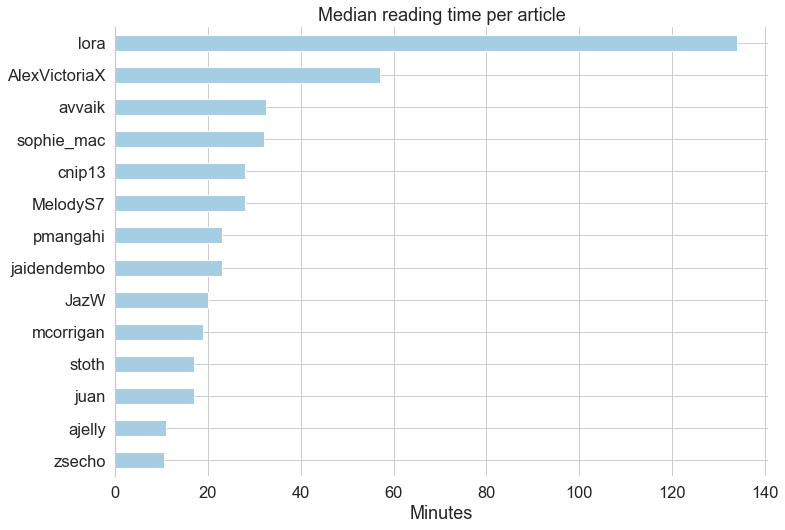

In [283]:
reading_times = pd.DataFrame(
    columns=["reading_id", "week", "user", "mins", "comments"])
usernames = comments.user.unique()

for user in usernames:
    for uid in comments.reading_id.unique():
        c = comments[(comments.user == user) & (comments.reading_id == uid)]
        count = len(c)
        if count > 1:
            reading_time = max(c.created)-min(c.updated)
            reading_time = int(reading_time.seconds // 60)
            reading_times.loc[len(reading_times)+1] = [uid,
                                                       c.week.iloc[0], user, reading_time, count]
reading_times.mins = reading_times.mins.astype(int)
reading_times.comments = reading_times.comments.astype(int)

pd.DataFrame(reading_times.groupby("user")['mins'].median()).sort_values(
    by="mins").plot(kind="barh", legend=False)
plt.title("Median reading time per article")
plt.xlabel("Minutes")
plt.ylabel("")
sns.despine(right=True, top=True, bottom=True)

if savefigs:
    plt.savefig(str(plot_dir / "reading_times.png"), bbox_inches="tight")

## Comments with URLs

What about annotations that link to other material?
Is that a particularly engaging activity?

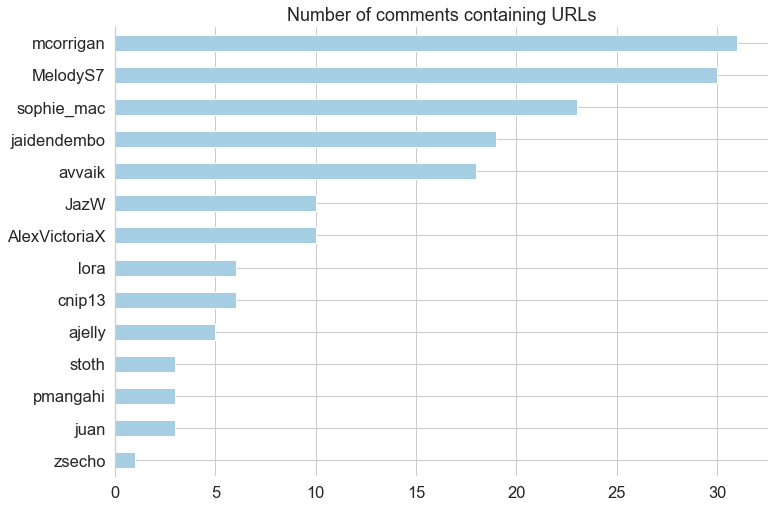

In [284]:
pdf = comments.groupby("user")['Has URL'].apply(
    lambda x: sum([int(y) if not pd.isna(y) else 0 for y in x]))
pd.DataFrame(pdf).sort_values(by="Has URL").plot(kind="barh", legend=False)
plt.title("Number of comments containing URLs")
plt.ylabel("")
sns.despine(right=True, bottom=True, top=True)

if savefigs:
    plt.savefig(str(plot_dir / "comments_with_urls.png"), bbox_inches="tight")